# Курсовой проект для курса "Python для Data Science"
## Задание:
Используя данные из train.csv, построить модель для предсказания цен на недвижимость (квартиры). С помощью полученной модели предсказать цены для квартир из файла test.csv.

## Целевая переменная:
Price

## Метрика:
R2 - коэффициент детерминации (sklearn.metrics.r2_score)

## Сдача проекта:
1. Прислать в раздел Задания Урока 10 ("Вебинар. Консультация по итоговому проекту") ссылку на программу в github (программа должна содержаться в файле Jupyter Notebook  с расширением ipynb). (Pull request не нужен, только ссылка ведущая на сам скрипт).
2. Приложить файл с названием по образцу SShirkin_predictions.csv с предсказанными ценами для квартир из test.csv (файл должен содержать два поля: Id, Price). В файле с предсказаниями должна быть 5001 строка (шапка + 5000 предсказаний).

## Сроки и условия сдачи:
Дедлайн: сдать проект нужно в течение 72 часов после начала Урока 10 ("Вебинар. Консультация по итоговому проекту").
Для успешной сдачи должны быть все предсказания (для 5000 квартир) и R2 должен быть больше 0.6.
При сдаче до дедлайна результат проекта может попасть в топ лучших результатов.
Повторная сдача и проверка результатов возможны только при условии предыдущей неуспешной сдачи.
Успешный проект нельзя пересдать в целях повышения результата.
Проекты, сданные после дедлайна или сданные повторно, не попадают в топ лучших результатов, но можно узнать результат.
В качестве итогового результата берется первый успешный результат, последующие успешные результаты не учитываются.

## Примечания:
Все файлы csv должны содержать названия полей (header - то есть "шапку"), разделитель - запятая.
В файлах не должны содержаться индексы из датафрейма.
Самая сложная из допустимых моделей - RandomForestRegressor из sklearn.

# Импорт данных

In [939]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%config IPCompleter.greedy=True
%config InlineBackend.figure_format = 'jpeg'
%matplotlib inline
pd.options.display.max_columns = 100

In [940]:
data = pd.read_csv('train.csv')
data.head(3)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524


In [941]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
Id               10000 non-null int64
DistrictId       10000 non-null int64
Rooms            10000 non-null float64
Square           10000 non-null float64
LifeSquare       7887 non-null float64
KitchenSquare    10000 non-null float64
Floor            10000 non-null int64
HouseFloor       10000 non-null float64
HouseYear        10000 non-null int64
Ecology_1        10000 non-null float64
Ecology_2        10000 non-null object
Ecology_3        10000 non-null object
Social_1         10000 non-null int64
Social_2         10000 non-null int64
Social_3         10000 non-null int64
Healthcare_1     5202 non-null float64
Helthcare_2      10000 non-null int64
Shops_1          10000 non-null int64
Shops_2          10000 non-null object
Price            10000 non-null float64
dtypes: float64(8), int64(9), object(3)
memory usage: 1.5+ MB


# One Hot Encoding

Смотрим количество уникальных значений, чтобы мы не разорвались по памяти

In [942]:
print('Ecology_2 unique:', data['Ecology_2'].unique())
print('Ecology_3 unique:', data['Ecology_3'].unique())
print('Shops_2 unique:', data['Shops_2'].unique())

Ecology_2 unique: ['B' 'A']
Ecology_3 unique: ['B' 'A']
Shops_2 unique: ['B' 'A']


In [943]:
def one_hot_encoder(adata):
    adata = pd.get_dummies(adata, columns=['Ecology_2', 'Ecology_3', 'Shops_2'])
    adata.drop(columns=['Ecology_2_A', 'Ecology_3_A', 'Shops_2_A'], inplace=True)
    adata.rename(columns={'Ecology_2_B': 'Ecology_2', 'Ecology_3_B': 'Ecology_3', 'Shops_2_B': 'Shops_2'}, inplace=True)
    return adata


data = one_hot_encoder(data.copy())
data.head(3)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price,Ecology_2,Ecology_3,Shops_2
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,33,7976,5,NaN,0,11,184966.930730,1,1,1
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,46,10309,1,240.0,1,16,300009.450063,1,1,1
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,34,7759,0,229.0,1,3,220925.908524,1,1,1


# Модели

Обучим на идеальном подмножестве выборки данных модели, которые исправят выбросы в данных

In [944]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score


def model_fit(x_train, x_test, y_train, y_test):
    clf = GridSearchCV(estimator=RandomForestRegressor(random_state=42),
                       param_grid=[{'n_estimators': [100], 'max_depth': [3, 5, 9, 15, 27]}],
                       cv=5)
    clf.fit(x_train, y_train)
    print('r2:', r2_score(y_test, clf.predict(x_test)))
    return clf


def show_model(clf_model):
    print('Лучшие параметры модели:', clf_model.best_params_)
    for mean, std, params in zip(clf_model.cv_results_['mean_test_score'], clf_model.cv_results_['std_test_score'], clf_model.cv_results_['params']):
        print("%0.4f (±%0.4f) for %r" % (mean, std * 2, params))

# Подготавливаем неправильно вбитые данные
## Swap bigger 'LifeSquare' with 'Square'

In [945]:
def swap_lifesquare_with_square(adata):
    tmp_filter_col = lambda df: (df['LifeSquare'].notna()) & (df['LifeSquare'] > df['Square'])
    adata['tmp_filter_col'] = tmp_filter_col(adata)
    print('Before LifeSquare⇔Square swap: ', adata.loc[tmp_filter_col, 'Id'].count())
    adata.loc[adata['tmp_filter_col'], 'LifeSquare'], adata.loc[adata['tmp_filter_col'], 'Square'] = adata.loc[adata['tmp_filter_col'], 'Square'], adata.loc[adata['tmp_filter_col'], 'LifeSquare']
    print('After LifeSquare⇔Square swap: ', adata.loc[tmp_filter_col, 'Id'].count())
    adata.drop(columns=['tmp_filter_col'], inplace=True)
    return adata
data = swap_lifesquare_with_square(data.copy())

Before LifeSquare⇔Square swap:  482
After LifeSquare⇔Square swap:  0


## Swap bigger 'Floor' with 'HouseFloor'

In [946]:
def swap_floor_with_housefloor(adata):
    tmp_filter_col = lambda df: (df['HouseFloor'] > 0) & (df['Floor'] > df['HouseFloor'])
    adata['tmp_filter_col'] = tmp_filter_col(adata)
    print('Before Floor⇔HouseFloor swap: ', adata.loc[tmp_filter_col, 'Id'].count())
    adata.loc[adata['tmp_filter_col'], 'Floor'], adata.loc[adata['tmp_filter_col'], 'HouseFloor'] = adata.loc[adata['tmp_filter_col'], 'HouseFloor'], adata.loc[adata['tmp_filter_col'], 'Floor']
    print('After Floor⇔HouseFloor swap: ', adata.loc[tmp_filter_col, 'Id'].count())
    adata.drop(columns=['tmp_filter_col'], inplace=True)
    return adata
data = swap_floor_with_housefloor(data.copy())

Before Floor⇔HouseFloor swap:  1556
After Floor⇔HouseFloor swap:  0


In [947]:
data.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price,Ecology_2,Ecology_3,Shops_2
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,57.223484,36.048753,6.273300,7.943200,13.192900,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399,0.990300,0.972500,0.917500
std,4859.01902,43.587592,0.839512,77.309420,19.372398,28.560917,5.228127,6.372139,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865,0.098015,0.163543,0.275139
min,0.00000,0.000000,0.000000,2.377248,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028,0.000000,0.000000,0.000000
25%,4169.50000,20.000000,1.000000,41.866858,22.765174,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942,1.000000,1.000000,1.000000
50%,8394.50000,36.000000,2.000000,52.633651,32.760108,6.000000,7.000000,14.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879,1.000000,1.000000,1.000000
75%,12592.50000,75.000000,2.000000,66.004634,45.029599,9.000000,11.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171,1.000000,1.000000,1.000000
max,16798.00000,209.000000,19.000000,7480.592129,638.163193,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570,1.000000,1.000000,1.000000


# Выбросы HouseYear

In [948]:
def fix_houseyear(adata, hy_median):
    invalid_hy_filter = lambda df: ((df['HouseYear'] < 1900) | (df['HouseYear'] > 2030))
    adata.loc[lambda df: invalid_hy_filter(df), 'HouseYear'] = hy_median
    return adata

In [949]:
hy_median = data['HouseYear'].median()
data = fix_houseyear(data.copy(), hy_median)
data.loc[:, ['HouseYear']].describe()

,HouseYear
count,10000.000000
mean,1984.863800
std,18.409979
min,1910.000000
25%,1974.000000
50%,1977.000000
75%,2001.000000
max,2020.000000


# Выбросы HouseFloor

In [950]:
def fix_housefloor(adata, hf_basedon_year, hf_median):
    invalid_hf_filter = lambda df: ((df['HouseFloor'] < 1) | (df['HouseFloor'] > 50))
    fixed_hf = adata.loc[lambda df: invalid_hf_filter(df), 'HouseYear'].map(lambda yr: hf_basedon_year.get(yr, default=hf_median))
    adata.loc[lambda df: invalid_hf_filter(df), 'HouseFloor'] = fixed_hf
    return adata

In [951]:
hf_basedon_year = data.groupby('HouseYear')['HouseFloor'].median()
hf_median = data['HouseYear'].median()
data = fix_housefloor(data.copy(), hf_basedon_year,  hf_median)
data.loc[:, ['HouseFloor']].describe()

,HouseFloor
count,10000.000000
mean,13.623800
std,5.794811
min,1.000000
25%,9.000000
50%,14.000000
75%,17.000000
max,48.000000


# Отсутствующие значения Healthcare_1

In [952]:
healthcare_corr = data.loc[data_final['Healthcare_1'].notnull(), :].corr().loc[lambda df: (np.abs(df['Healthcare_1']) > 0.1) & (np.abs(df['Healthcare_1']) < 1), ['Healthcare_1']]
healthcare_corr

,Healthcare_1
DistrictId,0.304335
Floor,-0.112202
HouseFloor,-0.191400
HouseYear,-0.205125
Social_3,0.133877
Helthcare_2,0.203177
Price,0.138755
Ecology_3,-0.114715


In [953]:
x_train, x_test, y_train, y_test = train_test_split(
    data.loc[lambda df: df['Healthcare_1'].notnull(), ['DistrictId', 'Floor', 'HouseFloor', 'HouseYear', 'Social_3', 'Helthcare_2', 'Ecology_3']],
    data.loc[lambda df: df['Healthcare_1'].notnull(), 'Healthcare_1'],
    test_size=0.25,
    random_state=42
)
clf_healthcare = model_fit(x_train, x_test, y_train, y_test)
show_model(clf_healthcare)

r2: 0.9858626888672526
Лучшие параметры модели: {'max_depth': 27, 'n_estimators': 100}
0.3687 (±0.0399) for {'max_depth': 3, 'n_estimators': 100}
0.6467 (±0.0514) for {'max_depth': 5, 'n_estimators': 100}
0.9303 (±0.0332) for {'max_depth': 9, 'n_estimators': 100}
0.9689 (±0.0225) for {'max_depth': 15, 'n_estimators': 100}
0.9692 (±0.0224) for {'max_depth': 27, 'n_estimators': 100}


In [954]:
def fix_healthcare1(adata, model):
    hc1_filter = lambda df: df['Healthcare_1'].isnull()
    features = adata.loc[lambda df: hc1_filter(df), ['DistrictId', 'Floor', 'HouseFloor', 'HouseYear', 'Social_3', 'Helthcare_2', 'Ecology_3']]
    adata.loc[lambda df: hc1_filter(df), 'Healthcare_1'] = model.predict(features)
    return adata


data = fix_healthcare1(data.copy(), clf_healthcare)

# Выбросы Rooms

In [955]:
data['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

Отфильтровано: 17 из 10000


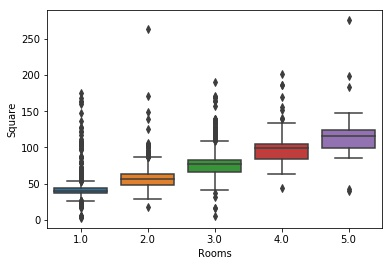

In [956]:
rooms_filter = lambda df: (df['Rooms'] >= 1) & (df['Rooms'] <= 5) & (df['Square'] <= 400)
print('Отфильтровано:', len(data.loc[lambda df: ~rooms_filter(df), 'Rooms']), 'из', len(data['Rooms']))
sns.boxplot(data.loc[lambda df: rooms_filter(df), 'Rooms'], data.loc[lambda df: rooms_filter(df), 'Square'])

In [957]:
square_quantiles = data.loc[lambda df: rooms_filter(df), :].groupby('Rooms')[['Square']].quantile(q=[0.25, 0.5, 0.75], interpolation='nearest')
square_quantiles

Square
Rooms                 
1.0   0.25   36.730798
      0.50   40.504282
      0.75   43.656886
2.0   0.25   47.885352
      0.50   55.896394
      0.75   63.456181
3.0   0.25   66.033045
      0.50   77.466387
      0.75   83.268318
4.0   0.25   83.833387
      0.50   98.686703
      0.75  104.769022
5.0   0.25   95.617533
      0.50  114.313752
      0.75  124.933289

In [958]:
def fix_rooms(adata):
    adata.loc[lambda df: df['Square'] < 45, 'Rooms'] = 1.0
    adata.loc[lambda df: (df['Square'] >= 45) & (df['Square'] < 65), 'Rooms'] = 2.0
    adata.loc[lambda df: (df['Square'] >= 65) & (df['Square'] < 85), 'Rooms'] = 3.0
    adata.loc[lambda df: (df['Square'] >= 85) & (df['Square'] < 100), 'Rooms'] = 4.0
    adata.loc[lambda df: df['Square'] > 100, 'Rooms'] = 5.0
    return adata


fix_rooms(data.copy()).corr().where(lambda v: (np.abs(v) > 0.1) & (np.abs(v) < 1))[['Rooms']].dropna().sort_values('Rooms', ascending=False)

,Rooms
LifeSquare,0.685835
Price,0.564593
Square,0.268729
HouseYear,0.155315
HouseFloor,0.120555


In [959]:
data = fix_rooms(data.copy())

# Выбросы KitchenSquare

Отфильтровано: 3198 из 10000


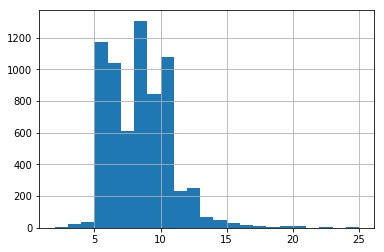

In [936]:
ks_filter = lambda df: (df['KitchenSquare'] >= 2) & (df['KitchenSquare'] <= 25)
print('Отфильтровано:', len(data.loc[lambda df: ~ks_filter(df), 'KitchenSquare']), 'из', len(data['KitchenSquare']))
data.loc[lambda df: ks_filter(df), 'KitchenSquare'].hist(bins=23)

In [937]:
data.loc[lambda df: ks_filter(df), :].corr().where(lambda v: (np.abs(v) > 0.1) & (np.abs(v) < 1))[['KitchenSquare']].dropna().sort_values('KitchenSquare', ascending=False)

,KitchenSquare
HouseYear,0.576003
HouseFloor,0.554335
Square,0.464337
Rooms,0.449953
Floor,0.327625
LifeSquare,0.308310
Price,0.286691
DistrictId,-0.109553
Healthcare_1,-0.118158
Helthcare_2,-0.120802


In [938]:
x_train, x_test, y_train, y_test = train_test_split(
    data.loc[lambda df: ks_filter(df), ['HouseYear', 'HouseFloor', 'DistrictId', 'Floor', 'Healthcare_1', 'Helthcare_2', 'Social_1', 'Rooms']],
    data.loc[lambda df: ks_filter(df), 'KitchenSquare'],
    test_size=0.25,
    random_state=42
)
clf_kitchen = model_fit(x_train, x_test, y_train, y_test)
show_model(clf_kitchen)

r2: 0.609289303883703
Лучшие параметры модели: {'max_depth': 9, 'n_estimators': 100}
0.5378 (±0.0380) for {'max_depth': 3, 'n_estimators': 100}
0.6075 (±0.0504) for {'max_depth': 5, 'n_estimators': 100}
0.6318 (±0.0595) for {'max_depth': 9, 'n_estimators': 100}
0.6228 (±0.0577) for {'max_depth': 15, 'n_estimators': 100}
0.6201 (±0.0595) for {'max_depth': 27, 'n_estimators': 100}


# Корелляция

In [831]:
perceptible_corr = data.drop(columns='Id').corr().where(lambda v: (np.abs(v) > 0.1) & (np.abs(v) < 1))
perceptible_corr

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B
DistrictId,NaN,NaN,NaN,NaN,NaN,NaN,-0.219881,-0.201194,NaN,0.246463,0.167479,0.136095,0.325897,0.306147,0.174214,0.265100,NaN,NaN,NaN,NaN,NaN,NaN
Rooms,NaN,NaN,0.193684,0.568671,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.550291,NaN,NaN,NaN,NaN,NaN,NaN
Square,NaN,0.193684,NaN,0.241954,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.142499,NaN,NaN,NaN,NaN,NaN,NaN
LifeSquare,NaN,0.568671,0.241954,NaN,NaN,NaN,NaN,0.170046,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.401445,NaN,NaN,NaN,NaN,NaN,NaN
KitchenSquare,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Floor,NaN,NaN,NaN,NaN,NaN,NaN,0.598678,0.258989,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.113605,NaN,NaN,NaN,NaN,NaN,NaN
HouseFloor,-0.219881,NaN,NaN,NaN,NaN,0.598678,NaN,0.461408,NaN,-0.106483,NaN,NaN,-0.159753,-0.140463,NaN,0.107305,NaN,NaN,NaN,NaN,NaN,NaN
HouseYear,-0.201194,NaN,NaN,0.170046,NaN,0.258989,0.461408,NaN,NaN,NaN,NaN,NaN,-0.193445,-0.116430,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Ecology_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.124068,NaN,NaN,NaN,NaN,0.110725,-0.110725,0.223197,-0.223197,NaN,NaN
Social_1,0.246463,NaN,NaN,NaN,NaN,NaN,-0.106483,NaN,NaN,NaN,0.955988,NaN,0.158952,0.524593,0.526272,0.263286,NaN,NaN,NaN,NaN,-0.144644,0.144644


Колонки, влияющие на цену

In [832]:
price_corr_columns = perceptible_corr[['Price']].dropna().sort_values('Price', ascending=False)
print(price_corr_columns.index.values)
price_corr_columns

['Rooms' 'LifeSquare' 'DistrictId' 'Social_1' 'Helthcare_2' 'Social_2'
 'Healthcare_1' 'Shops_1' 'Square' 'Floor' 'HouseFloor']


,Price
Rooms,0.550291
LifeSquare,0.401445
DistrictId,0.265100
Social_1,0.263286
Helthcare_2,0.253090
Social_2,0.239226
Healthcare_1,0.181519
Shops_1,0.180876
Square,0.142499
Floor,0.113605


# Выбросы RSL (Rooms, Square, LifeSquare)

Почти всегда данные имеют различные выброс и просто неверные значения, которые тем или иным способом попали в датасет. Найдём самое чистое подмножество этих данных и, на основе его значений, исправим остальные.

## Исследуем данные

Начинаем с 'Rooms', 'Square', 'LifeSquare' как с самых сильных признаков, влияющие на колонку Price, обладающих сильной корреляцией между собой.

In [740]:
data.corr().loc[:, ['Rooms', 'Square', 'LifeSquare']].where(lambda df: np.abs(df) > 0.1).dropna(how='all')

,Rooms,Square,LifeSquare
Rooms,1.000000,0.193684,0.521674
Square,0.193684,1.000000,0.219987
LifeSquare,0.521674,0.219987,1.000000
HouseFloor,NaN,NaN,0.104025
HouseYear,NaN,NaN,0.180189
Social_1,NaN,NaN,-0.133789
Social_2,NaN,NaN,-0.101346
Price,0.550291,0.142499,0.363570


### Фильтр 'Rooms'

In [741]:
data.corr().loc[lambda df: np.abs(df['Rooms']) > 0.1, ['Rooms']].sort_values('Rooms', ascending=False)

,Rooms
Rooms,1.000000
Price,0.550291
LifeSquare,0.521674
Square,0.193684


In [742]:
data['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

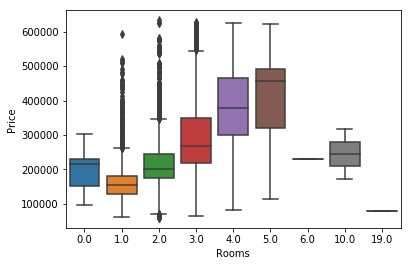

In [743]:
sns.boxplot(data['Rooms'], data['Price'])

Из графиков видно, что самые чистые данные находятся для 1 <= Rooms <= 5 в пределах 1 и 3 квартилей. Остальные, скорее всего, были заполнены с ошибками.

Составим фильтр, который выделит подмножество с идеальным отношением Rooms ∝ Square ∧ LifeSquare

In [744]:
ideal_rooms_filter = lambda df: df['Rooms'].isin([1, 2, 3, 4, 5])
ideal_rooms_data = data.loc[lambda df: ideal_rooms_filter(df), :]
print('Число записей: ', ideal_rooms_data['Id'].count(), '/', data['Id'].count())
ideal_rooms_data['Rooms'].value_counts()

Число записей:  9988 / 10000


2.0    3880
1.0    3705
3.0    2235
4.0     150
5.0      18
Name: Rooms, dtype: int64

### Фильтр 'LifeSquare'

In [745]:
lifesquare_quantiles = ideal_rooms_data.groupby('Rooms')[['LifeSquare']].quantile(q=[0.25, 0.75], interpolation='nearest')
lifesquare_quantiles

LifeSquare
Rooms                 
1.0   0.25   19.677872
      0.75   24.224435
2.0   0.25   29.914386
      0.75   36.005792
3.0   0.25   43.669819
      0.75   51.661600
4.0   0.25   53.804087
      0.75   72.482796
5.0   0.25   69.033727
      0.75   88.492650

Число записей:  5899 / 10000


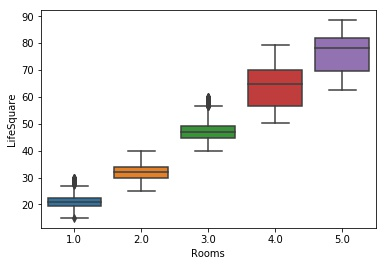

In [746]:
ideal_lifesquare_filter = lambda df: (
    (df['LifeSquare'].notna()) &
    (df['Square'] < 200) &
    (df['LifeSquare'] > 10) &
    (df['LifeSquare'] < 150) &
    (df['LifeSquare'] < df['Square'] * 0.9) &
    (df['LifeSquare'] > df['Square'] * 0.3) &
    ((df['Rooms'] == 1) & (df['LifeSquare'] >= 15) & (df['LifeSquare'] <= 30)) |
    ((df['Rooms'] == 2) & (df['LifeSquare'] >= 25) & (df['LifeSquare'] <= 40)) |
    ((df['Rooms'] == 3) & (df['LifeSquare'] >= 40) & (df['LifeSquare'] <= 60)) |
    ((df['Rooms'] == 4) & (df['LifeSquare'] >= 50) & (df['LifeSquare'] <= 80)) |
    ((df['Rooms'] == 5) & (df['LifeSquare'] >= 60) & (df['LifeSquare'] <= 100))
)
ideal_lifesquare_data = data.loc[lambda df: ideal_rooms_filter(df) & ideal_lifesquare_filter(df), :]
print('Число записей: ', ideal_lifesquare_data['Id'].count(), '/', data['Id'].count())
ideal_lifesquare_data['Rooms'].value_counts()
sns.boxplot(ideal_lifesquare_data['Rooms'], ideal_lifesquare_data['LifeSquare'])

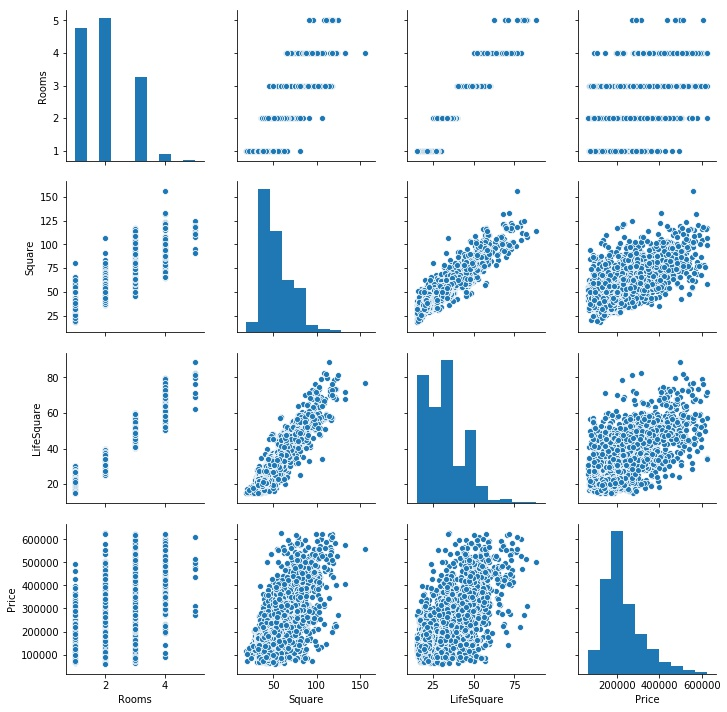

In [747]:
sns.pairplot(ideal_lifesquare_data.loc[:, ['Rooms', 'Square', 'LifeSquare', 'Price']])

### Фильтр 'Square'

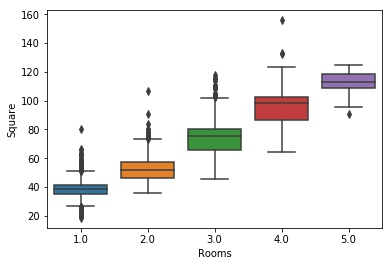

In [748]:
sns.boxplot(ideal_lifesquare_data['Rooms'], ideal_lifesquare_data['Square'])

In [749]:
square_quantiles = ideal_lifesquare_data.groupby('Rooms')[['Square']].quantile(q=[0.25, 0.75], interpolation='nearest')
square_quantiles

Square
Rooms                 
1.0   0.25   35.424208
      0.75   41.627859
2.0   0.25   46.357721
      0.75   57.088702
3.0   0.25   65.540129
      0.75   80.202766
4.0   0.25   86.482556
      0.75  102.929692
5.0   0.25  108.057398
      0.75  118.871952

Число записей:  5349 / 10000


2.0    2136
1.0    1945
3.0    1180
4.0      78
5.0      10
Name: Rooms, dtype: int64

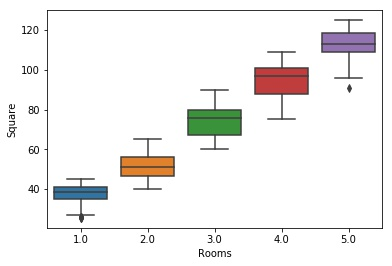

In [751]:
ideal_square_filter = lambda df: (
    ((df['Rooms'] == 1) & (df['Square'] >= 25) & (df['Square'] <= 45)) |
    ((df['Rooms'] == 2) & (df['Square'] >= 40) & (df['Square'] <= 65)) |
    ((df['Rooms'] == 3) & (df['Square'] >= 60) & (df['Square'] <= 90)) |
    ((df['Rooms'] == 4) & (df['Square'] >= 75) & (df['Square'] <= 110))|
    ((df['Rooms'] == 5) & (df['Square'] >= 90) & (df['Square'] <= 130))
)
ideal_square_data = data.loc[lambda df: ideal_square_filter(df) & ideal_rooms_filter(df) & ideal_lifesquare_filter(df), :]
sns.boxplot(ideal_square_data['Rooms'], ideal_square_data['Square'])
print('Число записей: ', ideal_square_data['Id'].count(), '/', data['Id'].count())
ideal_square_data['Rooms'].value_counts()

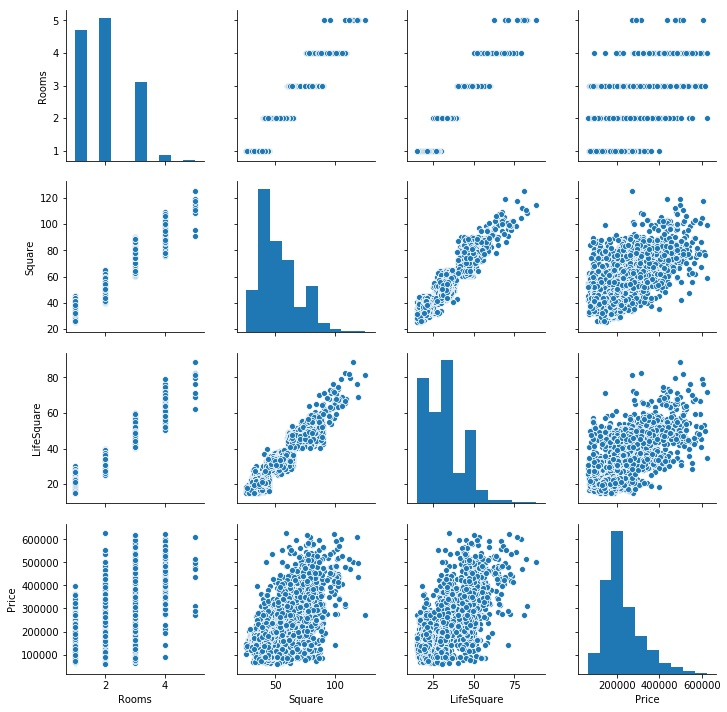

In [752]:
sns.pairplot(ideal_square_data.loc[:, ['Rooms', 'Square', 'LifeSquare', 'Price']])

### Итоговый RSL-фильтр

In [758]:
ideal_rsl_filter = lambda df: ideal_square_filter(df) & ideal_rooms_filter(df) & ideal_lifesquare_filter(df)

In [821]:
print('Корреляция до фильтрации:')
data.corr().loc[:, ['Rooms', 'Square', 'LifeSquare']].where(lambda df: np.abs(df) > 0.1).dropna(how='all')

Корреляция до фильтрации:


,Rooms,Square,LifeSquare
Rooms,1.000000,0.193684,0.568671
Square,0.193684,1.000000,0.241954
LifeSquare,0.568671,0.241954,1.000000
HouseYear,NaN,NaN,0.170046
Price,0.550291,0.142499,0.401445


In [822]:
print('Корреляция после фильтрации:')
data.loc[lambda df: ideal_rsl_filter(df), :].corr().loc[:, ['Rooms', 'Square', 'LifeSquare']].where(lambda df: np.abs(df) > 0.1).dropna(how='all')

Корреляция после фильтрации:


,Rooms,Square,LifeSquare
Rooms,1.000000,0.916155,0.964956
Square,0.916155,1.000000,0.942727
LifeSquare,0.964956,0.942727,1.000000
Floor,NaN,0.141491,NaN
HouseFloor,NaN,0.221204,NaN
HouseYear,NaN,0.166833,NaN
Price,0.631897,0.639687,0.659991


## Отсутствующие значения LifeSquare

Определим коэффициент зависимости LifeSquare от Square, используя линейную регрессию

In [960]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

for cols in [['Rooms'], ['Square'], ['Rooms', 'Square'], ['Rooms', 'Square', 'Floor', 'HouseFloor', 'HouseYear']]:
    # обучающая выборка
    x_train, x_test, y_train, y_test = train_test_split(
        data.loc[lambda df: df['LifeSquare'].notnull(), cols], 
        data.loc[lambda df: df['LifeSquare'].notnull(), 'LifeSquare'], 
        test_size=0.25, 
        random_state=42
    )
    # тренировка модели
    lr = LinearRegression()
    lr.fit(x_train, y_train)
    # результаты
    print('Для колонок:', cols)
    print('r2:', r2_score(y_test, lr.predict(x_test)))
    print('weights:', lr.coef_)
    print('intercept:', lr.intercept_)
    print()

Для колонок: ['Rooms']
r2: 0.5458014453316389
weights: [14.10802468]
intercept: 8.350971477427873

Для колонок: ['Square']
r2: 0.06775725276865241
weights: [0.04189597]
intercept: 33.81700989545388

Для колонок: ['Rooms', 'Square']
r2: 0.5481927547348449
weights: [1.38443484e+01 1.12402818e-02]
intercept: 8.231608115489276

Для колонок: ['Rooms', 'Square', 'Floor', 'HouseFloor', 'HouseYear']
r2: 0.5503762700759064
weights: [ 1.36941989e+01  1.10171679e-02  1.45000039e-01 -2.22161336e-01
  6.71169792e-02]
intercept: -122.98077971780573



In [823]:
def fix_lifesquare_na(adata):
    rooms_vals = adata.loc[lambda df: df['LifeSquare'].isnull(), 'Rooms']
    square_vals = adata.loc[lambda df: df['LifeSquare'].isnull(), 'Square']
    adata.loc[lambda df: df['LifeSquare'].isnull(), 'LifeSquare'] = 8.70500632 * rooms_vals  + 0.24948347 * square_vals
    return adata


data = fix_lifesquare_na(data.copy())
data.corr().loc[:, ['LifeSquare']].where(lambda df: (np.abs(df) > 0.1) & (np.abs(df) < 1)).dropna(how='all')

,LifeSquare
Rooms,0.568671
Square,0.241954
HouseYear,0.170046
Price,0.401445


## Модели RSL

### Модель для фиксов 'Rooms'

In [791]:
x_train, x_test, y_train, y_test = (
    data.loc[lambda df: ideal_rsl_filter(df), ['Square']], 
    data.loc[lambda df: ~ideal_rsl_filter(df), ['Square']], 
    data.loc[lambda df: ideal_rsl_filter(df), 'Rooms'],
    data.loc[lambda df: ~ideal_rsl_filter(df), 'Rooms']
)
clf_rooms = model_fit(x_train, x_test, y_train, y_test)
show_model(clf_rooms)

r2: -0.3504489503745225
Лучшие параметры модели: {'max_depth': 5, 'n_estimators': 100}
0.9060 (±0.0135) for {'max_depth': 5, 'n_estimators': 100}
0.9059 (±0.0136) for {'max_depth': 5, 'n_estimators': 250}
0.9059 (±0.0136) for {'max_depth': 5, 'n_estimators': 500}
0.8997 (±0.0137) for {'max_depth': 9, 'n_estimators': 100}
0.8996 (±0.0141) for {'max_depth': 9, 'n_estimators': 250}
0.8996 (±0.0141) for {'max_depth': 9, 'n_estimators': 500}
0.8830 (±0.0158) for {'max_depth': 15, 'n_estimators': 100}
0.8828 (±0.0169) for {'max_depth': 15, 'n_estimators': 250}
0.8828 (±0.0169) for {'max_depth': 15, 'n_estimators': 500}
0.8648 (±0.0189) for {'max_depth': 27, 'n_estimators': 100}
0.8646 (±0.0202) for {'max_depth': 27, 'n_estimators': 250}
0.8646 (±0.0196) for {'max_depth': 27, 'n_estimators': 500}


### Модель для фиксов 'Square'

In [796]:
x_train, x_test, y_train, y_test = (
    data.loc[lambda df: ideal_rsl_filter(df), ['Rooms', 'Floor', 'HouseFloor', 'HouseYear']], 
    data.loc[lambda df: ~ideal_rsl_filter(df), ['Rooms', 'Floor', 'HouseFloor', 'HouseYear']], 
    data.loc[lambda df: ideal_rsl_filter(df), 'Square'], 
    data.loc[lambda df: ~ideal_rsl_filter(df), 'Square']
)
clf_square = model_fit(x_train, x_test, y_train, y_test)
show_model(clf_square)

r2: 0.01457469560317648
Лучшие параметры модели: {'max_depth': 9, 'n_estimators': 250}
0.9303 (±0.0027) for {'max_depth': 5, 'n_estimators': 100}
0.9307 (±0.0027) for {'max_depth': 5, 'n_estimators': 250}
0.9366 (±0.0020) for {'max_depth': 9, 'n_estimators': 100}
0.9368 (±0.0018) for {'max_depth': 9, 'n_estimators': 250}
0.9292 (±0.0032) for {'max_depth': 15, 'n_estimators': 100}
0.9295 (±0.0030) for {'max_depth': 15, 'n_estimators': 250}
0.9267 (±0.0047) for {'max_depth': 27, 'n_estimators': 100}
0.9271 (±0.0041) for {'max_depth': 27, 'n_estimators': 250}


In [357]:
def fix_square(adata, rsl_filter, model_square, debug=True):
    if debug:
        print('Корелляция Square⇔Price до фиксов', adata.corr()['Square']['Price'])
    adata.loc[lambda df: ~rsl_filter(df), 'Square'] = model_square.predict(adata.loc[lambda d: ~rsl_filter(d), ['Rooms', 'LifeSquare']])
    if debug:
        print('Корелляция Square⇔Price после фиксов', adata.corr()['Square']['Price'])
    return adata

In [358]:
def fix_rooms(adata, rsl_filter, model_rooms, debug=True):
    if debug:
        print('Корелляция Rooms⇔Price до фиксов', adata.corr()['Rooms']['Price'])
    adata.loc[lambda df: ~rsl_filter(df), 'Rooms'] = model_rooms.predict(adata.loc[lambda df: ~rsl_filter(df), ['Square', 'LifeSquare']])
    if debug:
        print('Корелляция Rooms⇔Price после фиксов', adata.corr()['Rooms']['Price'])
    return adata

In [362]:
data = fix_lifesquare(data, ideal_rsl_filter, clf_lifesquare)
data = fix_rooms(data, ideal_rsl_filter, clf_rooms)
data = fix_square(data, ideal_rsl_filter, clf_square)
data.loc[:, ['Rooms', 'Square', 'LifeSquare', 'Price']].corr()

Корелляция LifeSquare⇔Price до фиксов 0.36356966846690975
Корелляция LifeSquare⇔Price после фиксов 0.5988531384962051
Корелляция Rooms⇔Price до фиксов 0.5502907269258719
Корелляция Rooms⇔Price после фиксов 0.5856898800295063
Корелляция Square⇔Price до фиксов 0.14249926312014716
Корелляция Square⇔Price после фиксов 0.5882434338142329


,Rooms,Square,LifeSquare,Price
Rooms,1.000000,0.930319,0.968063,0.585690
Square,0.930319,1.000000,0.960420,0.588243
LifeSquare,0.968063,0.960420,1.000000,0.598853
Price,0.585690,0.588243,0.598853,1.000000


# Собираем итоговый датафрейм

In [961]:
def preprocessData(df,
                   houseyear_median, housefloor_basedon_year, housefloor_median, healthcare_model
#                    ,filter_rsl,         model_rooms, model_square, model_lifesquare,
                  ):
    df = one_hot_encoder(df)  # 'Ecology_2', 'Ecology_3', 'Shops_2'
    df = swap_lifesquare_with_square(df.copy())  # подготавливаем 'LifeSquare', 'Square'
    df = swap_floor_with_housefloor(df.copy())  # подготавливаем 'Floor', 'HouseFloor'
    df = fix_houseyear(df.copy(), houseyear_median)  # исправляем HouseYear
    df = fix_housefloor(df.copy(), housefloor_basedon_year, housefloor_median)  # исправляем HouseFloor
    df = fix_healthcare1(df.copy(), healthcare_model)  # исправляем Healthcare_1
    df = fix_rooms(df.copy())  # исправляем Rooms
    df = fix_lifesquare_na(df.copy())  # заполняем пустые значения LifeSquare
#     df = fix_lifesquare(df.copy(), filter_rsl, model_lifesquare)  # исправляем LifeSquare
#     df = fix_square(df.copy(), filter_rsl, model_square)  # исправляем Square
    return df

data_final = preprocessData(pd.read_csv('train.csv'),
                            hy_median, hf_basedon_year, hf_median, clf_healthcare
#                             ,ideal_rsl_filter, clf_rooms, clf_square, clf_lifesquare
                           )

Before LifeSquare⇔Square swap:  482
After LifeSquare⇔Square swap:  0
Before Floor⇔HouseFloor swap:  1556
After Floor⇔HouseFloor swap:  0


# Масштабируем признаки

In [962]:
from sklearn.preprocessing import StandardScaler
train_columns = data_final.columns.copy().drop(['Id', 'Price'])
print('total features:', len(train_columns))
df_train = data_final.loc[:, train_columns]
df_test = data_final.loc[:, data_final.columns == 'Price']

scaler = StandardScaler()
df_train_scaled = scaler.fit_transform(df_train)
df_train_scaled = pd.DataFrame(df_train_scaled, columns=train_columns)
df_train_scaled.head(3)

total features: 18


,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Ecology_2,Ecology_3,Shops_2
0,-0.353348,-0.012591,-0.119551,-0.335775,-0.009569,-0.180418,-0.797961,-0.861739,-0.250529,0.474169,0.654880,-0.127533,-0.653717,-0.883480,1.408356,0.09897,0.16816,0.299864
1,-0.215687,1.011047,0.109438,0.241253,0.060460,-0.180418,-0.797961,-0.372849,-0.998053,1.215681,1.237169,-0.295384,-0.895595,-0.213923,2.448700,0.09897,0.16816,0.299864
2,0.059635,-1.036229,-0.158792,-0.349111,-0.219657,0.010865,-0.280230,-0.916060,-0.581588,0.531208,0.600720,-0.337347,-0.908365,-0.213923,-0.256195,0.09897,0.16816,0.299864


# Предсказание
Наблюдаем за изменением главной метрики

In [963]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
x_train, x_test, y_train, y_test = train_test_split(
    df_train_scaled, 
    df_test, 
    test_size=0.25, 
    random_state=42
)

## LinearRegression

In [964]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(x_train, y_train)
y_pred = lr.predict(x_test)
print('Начальное значение:', 0.4520388943512419)
r2_score(y_test, y_pred)

Начальное значение: 0.4520388943512419


0.4861734790782791

## DecisionTreeRegressor

In [965]:
from sklearn.tree import DecisionTreeRegressor
dtr = DecisionTreeRegressor(random_state=42, max_depth=9)
dtr.fit(x_train, y_train)
y_pred = dtr.predict(x_test)
print('Начальное значение:', 0.624564658797478)
r2_score(y_test, y_pred)

Начальное значение: 0.624564658797478


0.6314322895459333

## RandomForestRegressor с обучением на фолдах

In [966]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
clf_final = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42), 
    param_grid=[{'n_estimators': [10],  
                 'max_depth': [17],
                 'max_features': [9]}],
    cv=5
)
clf_final.fit(x_train, y_train)
#  {'max_depth': [9, 15, 17, 19, 27], 'max_features': [9, 15, 21], 'n_estimators': 10}
cell_index = clf_final.cv_results_['params'].index(clf_final.best_params_)
mean = clf_final.cv_results_['mean_test_score'][cell_index]
std = clf_final.cv_results_['std_test_score'][cell_index]
print("%0.4f (±%0.4f) for %r" % (mean, std * 2, clf_final.best_params_))
print('r2', r2_score(y_test, clf_final.predict(x_test)))

0.7123 (±0.0365) for {'max_depth': 17, 'max_features': 9, 'n_estimators': 10}
r2 0.6952359278623574


In [967]:
pd.Series(clf_final.best_estimator_.feature_importances_, index=train_columns).sort_values(ascending=False)

Square           0.265601
Rooms            0.131950
Social_1         0.111565
Social_2         0.078115
LifeSquare       0.068908
Social_3         0.059451
DistrictId       0.044598
Ecology_1        0.043374
Healthcare_1     0.037473
HouseYear        0.034302
KitchenSquare    0.030556
HouseFloor       0.028479
Helthcare_2      0.022838
Floor            0.021307
Shops_1          0.018847
Shops_2          0.001141
Ecology_3        0.000954
Ecology_2        0.000541
dtype: float64